In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('ggplot')

# Asset boom-busts and wealth inequality


## Are asset boom-busts episodes associated with increased wealth inequality?
To find out whether asset boom-busts are associated with increased inequality, I compare the difference in wealth inequality between periods of boom-bust to reference periods such an episode did not occur. 

# Are boom-busts more likely (and volatile) in situations of relative equality?

Experiment that moves the equality parameter from 1.00 to 0.01

Hypothesis: more unequal societies produce smaller bubbles. 

In [7]:
# how to test, vary starting inequality. 
params['ticks'] = 600
NRUNS = 10

In [8]:
params['strat_share_chartists'] = 0.85

In [9]:
init_equality = [x / 100.0 for x in range(1, 106, 5)]
init_equality = init_equality[::-1]

In [10]:
#init_equality

In [11]:
trdrs = []
orbs = []
for exp in range(len(init_equality)): 
    equality = init_equality[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_unequal(params, seed, equality)
        traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [12]:
# store init_inequality
full_init_equality = []
for exp in range(len(init_equality)):
    for seed in range(NRUNS):
        full_init_equality.append(init_equality[exp])

In [13]:
# calculate init gini
init_ginis = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-0] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[0] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[0])
    
    init_ginis.append(gini(wealth))

In [14]:
# collect price stdevs: 
stdevs_prices = []
for ob in orbs:
    stdevs_prices.append(np.std(ob.tick_close_price))

In [15]:
# determine if a boom-bust occured:


In [16]:
data_ineq_exp = pd.DataFrame({'stdev_p': stdevs_prices, 'init_ineq': full_init_equality, 'init_gini': init_ginis})
data_ineq_exp['const'] = 1

In [23]:
# split the stdevs in parts of NRUNS
stdev_averages = []
stdev_conf_interval_uppers = []
stdev_conf_intervals_lowers = []
av_ginis = []

for x in range(len(init_equality)):
    y = x * NRUNS
    g = stdevs_prices[y: y + NRUNS]
    stdev_averages.append(np.mean(g))
    av_ginis.append(np.mean(init_ginis[y: y + NRUNS]))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    stdev_conf_interval_uppers.append(upper)
    stdev_conf_intervals_lowers.append(lower)

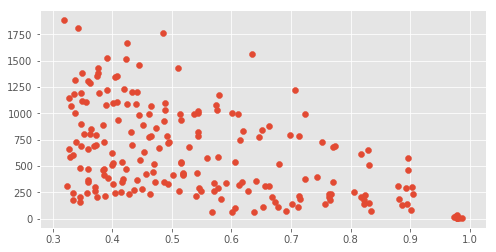

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=[8,4])

ax1.scatter(data_ineq_exp['init_gini'], data_ineq_exp['stdev_p'])

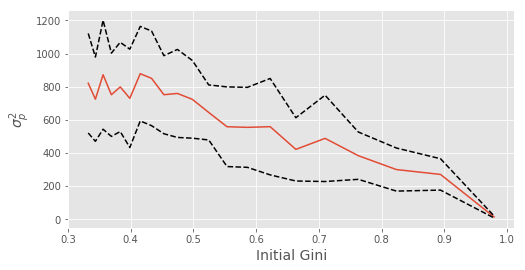

In [28]:
# TODO reverse picture

fig, ax1 = plt.subplots(1, 1, figsize=[8,4])

ax1.plot(av_ginis, stdev_averages)
ax1.plot(av_ginis, stdev_conf_interval_uppers, 'k--')
ax1.plot(av_ginis, stdev_conf_intervals_lowers, 'k--')

ax1.set_ylabel('$\sigma^2_p$', fontsize=14)
ax1.set_xlabel('Initial Gini', fontsize=14)

#ax2.scatter(data_ineq_exp['init_ineq'], data_ineq_exp['stdev_p'])

fig.savefig('init_inequality_price_stdev2.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [207]:
# Do regression
reg1_init_ineq = sm.OLS(endog=data_ineq_exp['stdev_p'], exog=data_ineq_exp[['const', 'init_gini']], missing='drop').fit()

In [208]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1_init_ineq],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Stdev price'],
                            info_dict=info_dict,
                            regressor_order=['const', 'init_gini'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

       Table - OLS Regressions
                     Stdev price     
-------------------------------------
const            683.5366***         
                 (67.3089)           
init_gini        -471.4376***        
                 (115.4444)          
R-squared        0.038365118055926795
No. observations 420                 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [209]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs)

In [210]:
# for every column... classify as boom-bust / or no boom-bust PD > 20
has_boom_bust = []

for col in (mc_prices / mc_fundamentals):
    if max((mc_prices / mc_fundamentals)[col]) > 10:
        has_boom_bust.append(1)
    else: 
        has_boom_bust.append(0)

In [211]:
# X is 
X = data_ineq_exp[['const', 'init_gini']]
y = pd.DataFrame({'boom_bust': has_boom_bust})

In [212]:
logit_regr = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.668676
         Iterations 5


In [213]:
logit_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              boom_bust   No. Observations:                  420
Model:                          Logit   Df Residuals:                      418
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 May 2019   Pseudo R-squ.:                 0.02759
Time:                        18:56:48   Log-Likelihood:                -280.84
converged:                       True   LL-Null:                       -288.81
                                        LLR p-value:                 6.546e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9838      0.320      3.071      0.002       0.356       1.612
init_gini     -2.1834      0.564     -3.873      0.000      -3.288      -1.078
==============================================================================
"""

I take the exponential of each of the coefficients to generate an odds ratios. This ratio signals how a 1 unit increase or decrease in a variable affects the odds of a boom-bust emerging.

In [214]:
logit_regr.conf_int()

,0,1
const,0.356009,1.611516
init_gini,-3.288461,-1.078383


In [215]:
confidenceInterval = logit_regr.conf_int()
confidenceInterval['OddsRatio'] = logit_regr.params
confidenceInterval.columns = ['2.5%', '97.5%', 'OddsRatio']
np.exp(confidenceInterval)

,2.5%,97.5%,OddsRatio
const,1.427620,5.010402,2.674500
init_gini,0.037311,0.340145,0.112655


### Generate bubble series

In [202]:
burn_in_period = 75

In [8]:
NRUNS = 1

In [4]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [205]:
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0
params['ticks'] = 400

In [207]:
params['strat_share_chartists'] = 0.65

In [208]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  20
Start of simulation  21
Start of simulation  22
Start of simulation  23
Start of simulation  24


In [209]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=burn_in_period)

In [210]:
ginis_diff = []
palmas_diff = []
twtws_diff = []

for idx, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[burn_in_period] for x in trdrs[idx]])
    stocks_start = np.array([x.var.stocks[burn_in_period] for x in trdrs[idx]])
    wealth_start = money_start + (stocks_start * orbs[idx].tick_close_price[burn_in_period])
    
    money_close = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks_close = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth_close = money_close + (stocks_close * orbs[idx].tick_close_price[-1])
    
    share_top_10_start = sum(np.sort(wealth_start)[int(len(wealth_start) * 0.9):]) / sum(wealth_start)
    share_bottom_40_start = sum(np.sort(wealth_start)[:int(len(wealth_start) * 0.4)]) / sum(wealth_start)
    share_top_10_close = sum(np.sort(wealth_close)[int(len(wealth_close) * 0.9):]) / sum(wealth_close)
    share_bottom_40_close = sum(np.sort(wealth_close)[:int(len(wealth_close) * 0.4)]) / sum(wealth_close)
    palmas_diff.append(share_top_10_close / share_bottom_40_close - share_top_10_start / share_bottom_40_start)
    
    share_top_20_start = sum(np.sort(wealth_start)[int(len(wealth_start) * 0.8):]) / sum(wealth_start)
    share_bottom_20_start = sum(np.sort(wealth_start)[:int(len(wealth_start) * 0.2)]) / sum(wealth_start)
    share_top_20_close = sum(np.sort(wealth_close)[int(len(wealth_close) * 0.8):]) / sum(wealth_close)
    share_bottom_20_close = sum(np.sort(wealth_close)[:int(len(wealth_close) * 0.2)]) / sum(wealth_close)
    twtws_diff.append(share_top_20_close / share_bottom_20_close - share_top_20_start / share_bottom_20_start)
    
    ginis_diff.append(gini(wealth_close) - gini(wealth_start))

### Generate non-bubble series

In [211]:
params['strat_share_chartists'] = 0.0

In [212]:
trdrs_f = []
orbs_f = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs_f.append(traders)
    orbs_f.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  20
Start of simulation  21
Start of simulation  22
Start of simulation  23
Start of simulation  24


In [213]:
mc_prices_f, mc_returns_f, mc_autocorr_returns_f, mc_autocorr_abs_returns_f, mc_volatility_f, mc_volume_f, mc_fundamentals_f = organise_data(orbs_f, burn_in_period=burn_in_period)

In [214]:
ginis_diff_f = []
palmas_diff_f = []
twtws_diff_f = []

for idx, traders_f in enumerate(trdrs_f):
    money_start_f = np.array([x.var.money[burn_in_period] for x in trdrs_f[idx]])
    stocks_start_f = np.array([x.var.stocks[burn_in_period] for x in trdrs_f[idx]])
    wealth_start_f = money_start_f + (stocks_start_f * orbs_f[idx].tick_close_price[burn_in_period])
    
    money_close_f = np.array([x.var.money[-1] for x in trdrs_f[idx]])
    stocks_close_f = np.array([x.var.stocks[-1] for x in trdrs_f[idx]])
    wealth_close_f = money_close_f + (stocks_close_f * orbs_f[idx].tick_close_price[-1])
    
    share_top_10_start_f = sum(np.sort(wealth_start_f)[int(len(wealth_start_f) * 0.9):]) / sum(wealth_start_f)
    share_bottom_40_start_f = sum(np.sort(wealth_start_f)[:int(len(wealth_start_f) * 0.4)]) / sum(wealth_start_f)
    share_top_10_close_f = sum(np.sort(wealth_close_f)[int(len(wealth_close_f) * 0.9):]) / sum(wealth_close_f)
    share_bottom_40_close_f = sum(np.sort(wealth_close_f)[:int(len(wealth_close_f) * 0.4)]) / sum(wealth_close_f)
    palmas_diff_f.append(share_top_10_close_f / share_bottom_40_close_f - share_top_10_start_f / share_bottom_40_start_f)
    
    share_top_20_start_f = sum(np.sort(wealth_start_f)[int(len(wealth_start_f) * 0.8):]) / sum(wealth_start_f)
    share_bottom_20_start_f = sum(np.sort(wealth_start_f)[:int(len(wealth_start_f) * 0.2)]) / sum(wealth_start_f)
    share_top_20_close_f = sum(np.sort(wealth_close_f)[int(len(wealth_close_f) * 0.8):]) / sum(wealth_close_f)
    share_bottom_20_close_f = sum(np.sort(wealth_close_f)[:int(len(wealth_close_f) * 0.2)]) / sum(wealth_close_f)
    twtws_diff_f.append(share_top_20_close_f / share_bottom_20_close_f - share_top_20_start_f / share_bottom_20_start_f)
    
    ginis_diff_f.append(gini(wealth_close_f) - gini(wealth_start_f))

## Compare populations

In [215]:
# compare ginis-palmas and twtws directly to counterpart withouth f 
t_test_score_gini, p_gini =  stats.ttest_rel(ginis_diff_f, ginis_diff)
t_test_score_palma, p_palma =  stats.ttest_rel(palmas_diff_f, palmas_diff)
t_test_score_twts, p_twts =  stats.ttest_rel(twtws_diff_f, twtws_diff)

In [216]:
print('av no boom-bust = ', np.mean(ginis_diff_f), 'av boom-bust gini = ', np.mean(ginis_diff))
print('Boom-bust effect gini', t_test_score_gini, p_gini )
print('')
print('av no boom-bust palma = ', np.mean(palmas_diff_f), 'av no boom-bust udget palma = ', np.mean(palmas_diff))
print('Boom-bust effect palma', t_test_score_palma, p_palma)
print('')
print('av no boom-bust twtw = ', np.mean(twtws_diff_f), 'av no budget twtw = ', np.mean(twtws_diff))
print('Boom-bust effect twtw', t_test_score_twts, p_twts)

av no boom-bust =  0.002518169743679485 av boom-bust gini =  0.4030167734739063
Boom-bust effect gini -15.625897698405733 4.44305088925935e-14

av no boom-bust palma =  0.011728043077539323 av no boom-bust udget palma =  11.79409021522342
Boom-bust effect palma -6.664089224586944 6.816991628461224e-07

av no boom-bust twtw =  0.04332615327227348 av no budget twtw =  43.09928621456077
Boom-bust effect twtw -7.985737241396046 3.257225647003354e-08


In [217]:
# Get the t-critical value**
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

In [218]:
boom_bust_effect_on_gini = np.array(ginis_diff) - np.array(ginis_diff_f)
av_effect_boom_bust_on_gini = np.mean(boom_bust_effect_on_gini)
lower_gini, upper_gini = confidence_interval(boom_bust_effect_on_gini, av_effect_boom_bust_on_gini)

boom_bust_effect_on_palma = np.array(palmas_diff) - np.array(palmas_diff_f)
av_effect_boom_bust_on_palma = np.mean(boom_bust_effect_on_palma)
lower_palma, upper_palma = confidence_interval(boom_bust_effect_on_palma, av_effect_boom_bust_on_palma)

boom_bust_effect_on_twtw = np.array(twtws_diff) - np.array(twtws_diff_f)
av_effect_boom_bust_on_twtw = np.mean(boom_bust_effect_on_twtw)
lower_twtw, upper_twtw = confidence_interval(boom_bust_effect_on_twtw, av_effect_boom_bust_on_twtw)

In [219]:
boom_bust_effect = pd.DataFrame({'gini': [lower_gini, av_effect_boom_bust_on_gini, upper_gini], 
                                 'palma': [lower_palma, av_effect_boom_bust_on_palma, upper_palma],
                                 'twtw': [lower_twtw, av_effect_boom_bust_on_twtw, upper_twtw]})

boom_bust_effect.index = ['Lower bound', 'Average', 'Upper bound']

In [220]:
boom_bust_effect

,gini,palma,twtw
Lower bound,0.102372,-8.782994,-19.657812
Average,0.400499,11.782362,43.055960
Upper bound,0.698625,32.347718,105.769732


In [221]:
# compare ginis-palmas and twtws directly to counterpart withouth f 
t_test_score_gini, p_gini =  stats.ttest_rel(ginis_diff, ginis_diff_f)
t_test_score_palma, p_palma =  stats.ttest_rel(palmas_diff, palmas_diff_f)
t_test_score_twts, p_twts =  stats.ttest_rel(twtws_diff, twtws_diff_f)

In [222]:
print('gini t-test', t_test_score_gini, 'p-val', p_gini)
print('palma t-test', t_test_score_palma, 'p-val', p_palma)
print('twtw t-test', t_test_score_twts, 'p-val', p_twts)

gini t-test 15.625897698405733 p-val 4.44305088925935e-14
palma t-test 6.664089224586944 p-val 6.816991628461224e-07
twtw t-test 7.985737241396046 p-val 3.257225647003354e-08


## Regression

inequality metric = cons + price_stdev + dummy_boom_bust

In [223]:
# create df with: gini_diffs, palma_diffs, twtws_diffs, stdev_prices, dummy_boom_busts
boom_bust_dummy = [0 for x in range(len(ginis_diff_f))] + [1 for x in range(len(ginis_diff))]
stdev_prices = [np.std(orbs_f[i].tick_close_price[burn_in_period:]) for i in range(len(orbs_f))] + [np.std(orbs[i].tick_close_price[burn_in_period:]) for i in range(len(orbs))]
gini_diffs = ginis_diff_f + ginis_diff
palma_diffs = palmas_diff_f + palmas_diff
twtws_diffs = twtws_diff_f + twtws_diff

In [224]:
long_data = pd.DataFrame({'gini_diffs': gini_diffs, 'palma_diffs': palma_diffs, 'twtw_diffs': twtws_diffs,
             'stdev_prices': stdev_prices, 'dummy_boom_busts': boom_bust_dummy})
long_data['const'] = 1

In [225]:
# 2 regression
reg1_long = sm.OLS(endog=long_data['gini_diffs'], exog=long_data[['const', 'stdev_prices', 'dummy_boom_busts']], missing='drop').fit()
reg2_long = sm.OLS(endog=long_data['palma_diffs'], exog=long_data[['const', 'stdev_prices', 'dummy_boom_busts']], missing='drop').fit()
reg3_long = sm.OLS(endog=long_data['twtw_diffs'], exog=long_data[['const', 'stdev_prices', 'dummy_boom_busts']], missing='drop').fit()

In [226]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1_long, reg2_long, reg3_long],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'stdev_prices', 'dummy_boom_busts'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                         Table - OLS Regressions
                        Gini              Palma              20-20       
-------------------------------------------------------------------------
const            0.0024             0.0092             0.0389            
                 (0.0182)           (1.2619)           (3.8513)          
stdev_prices     0.0000             0.0008             0.0013            
                 (0.0000)           (0.0023)           (0.0069)          
dummy_boom_busts 0.3901***          11.4326***         42.4359***        
                 (0.0299)           (2.0708)           (6.3200)          
R-squared        0.8372651137162583 0.4818279034035643 0.5709039915108203
No. observations 50                 50                 50                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Compare long-simulations 

In [158]:
burn_in_period = 0

In [159]:
NRUNS = 20

In [160]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [161]:
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0
params['ticks'] = 1200

In [162]:
params['strat_share_chartists'] = 0.75

In [163]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19


In [164]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=burn_in_period)

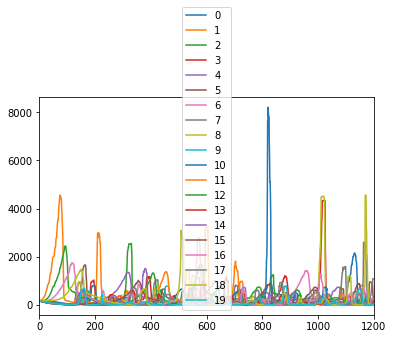

In [165]:
mc_prices.plot()

In [166]:
ginis_diff = []
palmas_diff = []
twtws_diff = []

for idx, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[burn_in_period] for x in trdrs[idx]])
    stocks_start = np.array([x.var.stocks[burn_in_period] for x in trdrs[idx]])
    wealth_start = money_start + (stocks_start * orbs[idx].tick_close_price[burn_in_period])
    
    money_close = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks_close = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth_close = money_close + (stocks_close * orbs[idx].tick_close_price[-1])
    
    share_top_10_start = sum(np.sort(wealth_start)[int(len(wealth_start) * 0.9):]) / sum(wealth_start)
    share_bottom_40_start = sum(np.sort(wealth_start)[:int(len(wealth_start) * 0.4)]) / sum(wealth_start)
    share_top_10_close = sum(np.sort(wealth_close)[int(len(wealth_close) * 0.9):]) / sum(wealth_close)
    share_bottom_40_close = sum(np.sort(wealth_close)[:int(len(wealth_close) * 0.4)]) / sum(wealth_close)
    palmas_diff.append(share_top_10_close / share_bottom_40_close - share_top_10_start / share_bottom_40_start)
    
    share_top_20_start = sum(np.sort(wealth_start)[int(len(wealth_start) * 0.8):]) / sum(wealth_start)
    share_bottom_20_start = sum(np.sort(wealth_start)[:int(len(wealth_start) * 0.2)]) / sum(wealth_start)
    share_top_20_close = sum(np.sort(wealth_close)[int(len(wealth_close) * 0.8):]) / sum(wealth_close)
    share_bottom_20_close = sum(np.sort(wealth_close)[:int(len(wealth_close) * 0.2)]) / sum(wealth_close)
    twtws_diff.append(share_top_20_close / share_bottom_20_close - share_top_20_start / share_bottom_20_start)
    
    ginis_diff.append(gini(wealth_close) - gini(wealth_start))

### Generate non-bubble series

In [167]:
params['strat_share_chartists'] = 0.0

In [168]:
trdrs_f = []
orbs_f = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs_f.append(traders)
    orbs_f.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19


In [169]:
mc_prices_f, mc_returns_f, mc_autocorr_returns_f, mc_autocorr_abs_returns_f, mc_volatility_f, mc_volume_f, mc_fundamentals_f = organise_data(orbs_f, burn_in_period=burn_in_period)

In [170]:
ginis_diff_f = []
palmas_diff_f = []
twtws_diff_f = []

for idx, traders_f in enumerate(trdrs_f):
    money_start_f = np.array([x.var.money[burn_in_period] for x in trdrs_f[idx]])
    stocks_start_f = np.array([x.var.stocks[burn_in_period] for x in trdrs_f[idx]])
    wealth_start_f = money_start_f + (stocks_start_f * orbs_f[idx].tick_close_price[burn_in_period])
    
    money_close_f = np.array([x.var.money[-1] for x in trdrs_f[idx]])
    stocks_close_f = np.array([x.var.stocks[-1] for x in trdrs_f[idx]])
    wealth_close_f = money_close_f + (stocks_close_f * orbs_f[idx].tick_close_price[-1])
    
    share_top_10_start_f = sum(np.sort(wealth_start_f)[int(len(wealth_start_f) * 0.9):]) / sum(wealth_start_f)
    share_bottom_40_start_f = sum(np.sort(wealth_start_f)[:int(len(wealth_start_f) * 0.4)]) / sum(wealth_start_f)
    share_top_10_close_f = sum(np.sort(wealth_close_f)[int(len(wealth_close_f) * 0.9):]) / sum(wealth_close_f)
    share_bottom_40_close_f = sum(np.sort(wealth_close_f)[:int(len(wealth_close_f) * 0.4)]) / sum(wealth_close_f)
    palmas_diff_f.append(share_top_10_close_f / share_bottom_40_close_f - share_top_10_start_f / share_bottom_40_start_f)
    
    share_top_20_start_f = sum(np.sort(wealth_start_f)[int(len(wealth_start_f) * 0.8):]) / sum(wealth_start_f)
    share_bottom_20_start_f = sum(np.sort(wealth_start_f)[:int(len(wealth_start_f) * 0.2)]) / sum(wealth_start_f)
    share_top_20_close_f = sum(np.sort(wealth_close_f)[int(len(wealth_close_f) * 0.8):]) / sum(wealth_close_f)
    share_bottom_20_close_f = sum(np.sort(wealth_close_f)[:int(len(wealth_close_f) * 0.2)]) / sum(wealth_close_f)
    twtws_diff_f.append(share_top_20_close_f / share_bottom_20_close_f - share_top_20_start_f / share_bottom_20_start_f)
    
    ginis_diff_f.append(gini(wealth_close_f) - gini(wealth_start_f))

## Compare populations

In [171]:
# compare ginis-palmas and twtws directly to counterpart withouth f 
t_test_score_gini, p_gini =  stats.ttest_rel(ginis_diff_f, ginis_diff)
t_test_score_palma, p_palma =  stats.ttest_rel(palmas_diff_f, palmas_diff)
t_test_score_twts, p_twts =  stats.ttest_rel(twtws_diff_f, twtws_diff)

In [172]:
print('av no boom-bust = ', np.mean(ginis_diff_f), 'av boom-bust gini = ', np.mean(ginis_diff))
print('Boom-bust effect gini', t_test_score_gini, p_gini )
print('')
print('av no boom-bust palma = ', np.mean(palmas_diff_f), 'av no boom-bust udget palma = ', np.mean(palmas_diff))
print('Boom-bust effect palma', t_test_score_palma, p_palma)
print('')
print('av no boom-bust twtw = ', np.mean(twtws_diff_f), 'av no budget twtw = ', np.mean(twtws_diff))
print('Boom-bust effect twtw', t_test_score_twts, p_twts)

av no boom-bust =  0.009655681632996654 av boom-bust gini =  0.5946998086585212
Boom-bust effect gini -23.65273412831302 1.4791925659203701e-15

av no boom-bust palma =  0.04282465649043967 av no boom-bust udget palma =  62.740443607578115
Boom-bust effect palma -3.263022833670634 0.004092142369122814

av no boom-bust twtw =  0.16759589129496022 av no budget twtw =  195.02389541769685
Boom-bust effect twtw -3.697702631151585 0.0015277234957900613


In [173]:
# Get the t-critical value**
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

In [174]:
boom_bust_effect_on_gini = np.array(ginis_diff) - np.array(ginis_diff_f)
av_effect_boom_bust_on_gini = np.mean(boom_bust_effect_on_gini)
lower_gini, upper_gini = confidence_interval(boom_bust_effect_on_gini, av_effect_boom_bust_on_gini)

boom_bust_effect_on_palma = np.array(palmas_diff) - np.array(palmas_diff_f)
av_effect_boom_bust_on_palma = np.mean(boom_bust_effect_on_palma)
lower_palma, upper_palma = confidence_interval(boom_bust_effect_on_palma, av_effect_boom_bust_on_palma)

boom_bust_effect_on_twtw = np.array(twtws_diff) - np.array(twtws_diff_f)
av_effect_boom_bust_on_twtw = np.mean(boom_bust_effect_on_twtw)
lower_twtw, upper_twtw = confidence_interval(boom_bust_effect_on_twtw, av_effect_boom_bust_on_twtw)

In [175]:
boom_bust_effect = pd.DataFrame({'gini': [lower_gini, av_effect_boom_bust_on_gini, upper_gini], 
                                 'palma': [lower_palma, av_effect_boom_bust_on_palma, upper_palma],
                                 'twtw': [lower_twtw, av_effect_boom_bust_on_twtw, upper_twtw]})

boom_bust_effect.index = ['Lower bound', 'Average', 'Upper bound']

In [176]:
boom_bust_effect

,gini,palma,twtw
Lower bound,0.327710,-137.205970,-353.385475
Average,0.585044,62.697619,194.856300
Upper bound,0.842378,262.601208,743.098074


In [177]:
# compare ginis-palmas and twtws directly to counterpart withouth f 
t_test_score_gini, p_gini =  stats.ttest_rel(ginis_diff, ginis_diff_f)
t_test_score_palma, p_palma =  stats.ttest_rel(palmas_diff, palmas_diff_f)
t_test_score_twts, p_twts =  stats.ttest_rel(twtws_diff, twtws_diff_f)

In [178]:
print('gini t-test', t_test_score_gini, 'p-val', p_gini)
print('palma t-test', t_test_score_palma, 'p-val', p_palma)
print('twtw t-test', t_test_score_twts, 'p-val', p_twts)

gini t-test 23.65273412831302 p-val 1.4791925659203701e-15
palma t-test 3.263022833670634 p-val 0.004092142369122814
twtw t-test 3.697702631151585 p-val 0.0015277234957900613


## Regression

inequality metric = cons + price_stdev + dummy_boom_bust

In [195]:
# create df with: gini_diffs, palma_diffs, twtws_diffs, stdev_prices, dummy_boom_busts
boom_bust_dummy = [0 for x in range(len(ginis_diff_f))] + [1 for x in range(len(ginis_diff))]
stdev_prices = [np.std(orbs_f[i].tick_close_price[burn_in_period:]) for i in range(len(orbs_f))] + [np.std(orbs[i].tick_close_price[burn_in_period:]) for i in range(len(orbs))]
gini_diffs = ginis_diff_f + ginis_diff
palma_diffs = palmas_diff_f + palmas_diff
twtws_diffs = twtws_diff_f + twtws_diff

In [197]:
long_data = pd.DataFrame({'gini_diffs': gini_diffs, 'palma_diffs': palma_diffs, 'twtw_diffs': twtws_diffs,
             'stdev_prices': stdev_prices, 'dummy_boom_busts': boom_bust_dummy})
long_data['const'] = 1

In [200]:
# 2 regression
reg1_long = sm.OLS(endog=long_data['gini_diffs'], exog=long_data[['const', 'stdev_prices', 'dummy_boom_busts']], missing='drop').fit()
reg2_long = sm.OLS(endog=long_data['palma_diffs'], exog=long_data[['const', 'stdev_prices', 'dummy_boom_busts']], missing='drop').fit()
reg3_long = sm.OLS(endog=long_data['twtw_diffs'], exog=long_data[['const', 'stdev_prices', 'dummy_boom_busts']], missing='drop').fit()

In [201]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1_long, reg2_long, reg3_long],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'stdev_prices', 'dummy_boom_busts'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                         Table - OLS Regressions
                        Gini               Palma              20-20       
--------------------------------------------------------------------------
const            0.0098             0.4809              1.2679            
                 (0.0177)           (13.5151)           (37.1792)         
stdev_prices     -0.0000            -0.0950             -0.2386           
                 (0.0001)           (0.0793)            (0.2182)          
dummy_boom_busts 0.5979***          94.7027***          275.2490***       
                 (0.0431)           (32.8468)           (90.3594)         
R-squared        0.9364939262394681 0.24801796131580267 0.2876457817788539
No. observations 40                 40                  40                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Long simulations 

In [3]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [9]:
NRUNS = 10

In [5]:
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0
params['ticks'] = 3000

In [10]:
share_chartists = [x / 100.0 for x in range(10, 110, 20)]
Experiments = len(share_chartists)
Experiments

5

In [11]:
share_chartists

[0.1, 0.3, 0.5, 0.7, 0.9]

## Run model and update chartists every time

In [13]:
trdrs = []
orbs = []
for exp in range(Experiments):
    params['strat_share_chartists'] = share_chartists[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        #traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0


C:\Users\joerischasfoort\Documents\GitHub\bubble-inequality\distribution_model.py:89: RuntimeWarning: overflow encountered in exp
  fcast_price = mid_price * np.exp(trader.exp.returns['stocks'])
C:\Users\joerischasfoort\Documents\GitHub\bubble-inequality\distribution_model.py:99: RuntimeWarning: invalid value encountered in double_scalars
  ) - (trader.var.stocks[-1] * trader_price)
C:\Users\joerischasfoort\Documents\GitHub\bubble-inequality\distribution_model.py:89: RuntimeWarning: overflow encountered in double_scalars
  fcast_price = mid_price * np.exp(trader.exp.returns['stocks'])


Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9


### Structure data

In [14]:
full_share_chartists = []
for exp in range(Experiments):
    for seed in range(NRUNS):
        full_share_chartists.append(share_chartists[exp])

In [15]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [19]:
# data = pd.DataFrame({'gini': np.log(ginis[:]), 'palma': np.log(palmas[:]), 'twtw': np.log(twtws[:]), 'pd_vol': price_to_div_stdev[:],
#                      'share_chartists': np.log(full_share_chartists[:]), 'perc_b_occur': perc_bubble_occur,
#                      'lin_share_chartists': full_share_chartists[:], 'asset_price_infl': asset_price_inflation[:]})

data = pd.DataFrame({'gini': ginis[:], 'palma': palmas[:], 'twtw': twtws[:], 'pd_vol': price_to_div_stdev[:],
                     'share_chartists': full_share_chartists[:],
                     'lin_share_chartists': full_share_chartists[:], 'asset_price_infl': asset_price_inflation[:]})
data['const'] = 1

In [28]:
# split the gisis in parts of 10 
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

twtw_averages = []
twtw_conf_interval_uppers = []
twtw_conf_intervals_lowers = []

price_div_stdev_av = []
price_div_stdev_uppers = []
price_div_stdev_lowers = []

for x in range(Experiments):
    y = x*10
    g = ginis[y:y+10]
    pstdev = price_to_div_stdev[y: y+10]
    
    price_div_stdev_av.append(np.mean(pstdev))
    #lower, upper = confidence_interval(g, np.median(pstdev))
    sample_stdev = np.std(pstdev)
    sigma = sample_stdev/math.sqrt(len(pstdev))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pstdev), scale = sigma) 
    price_div_stdev_uppers.append(upper)
    price_div_stdev_lowers.append(max(lower, 0))
    
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    #lower, upper = confidence_interval(g, np.median(g))
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+10]
    palma_averages.append(np.mean(p))
    #lower, upper = confidence_interval(p, np.median(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))
    
    tw = twtws[y:y+10]
    twtw_averages.append(np.mean(tw))
    #lower, upper = confidence_interval(tw, np.median(tw))
    sample_stdev = np.std(tw)
    sigma = sample_stdev/math.sqrt(len(tw))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(tw), scale = sigma) 
    twtw_conf_interval_uppers.append(upper)
    twtw_conf_intervals_lowers.append(max(lower, 0))

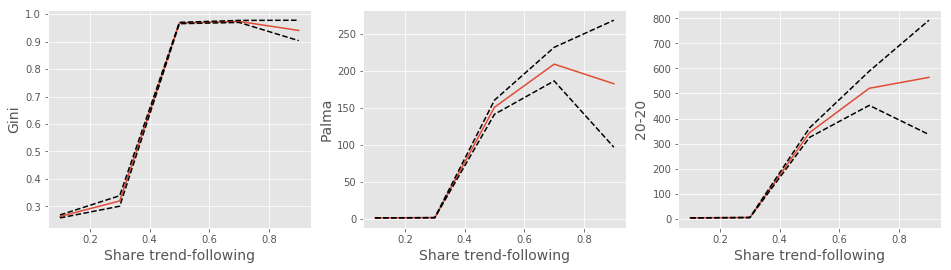

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.plot(share_chartists, gini_averages)
ax1.plot(share_chartists, gini_conf_interval_uppers, 'k--')
ax1.plot(share_chartists, gini_conf_intervals_lowers, 'k--')

ax2.plot(share_chartists, palma_averages)
ax2.plot(share_chartists, palma_conf_interval_uppers, 'k--')
ax2.plot(share_chartists, palma_conf_intervals_lowers, 'k--')

ax3.plot(share_chartists, twtw_averages)
ax3.plot(share_chartists, twtw_conf_interval_uppers, 'k--')
ax3.plot(share_chartists, twtw_conf_intervals_lowers, 'k--')

ax1.set_ylabel('Gini', fontsize=14)
ax2.set_ylabel('Palma', fontsize=14)
ax3.set_ylabel('20-20', fontsize=14)


for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Share trend-following', fontsize=14)

fig.savefig('share_chartists_inequality_long.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

### Hump-shaped pd volatility

In [39]:
len(orbs)

50

In [ ]:
orbs[idx].tick_close_price

In [1]:
# hump shaped price volatility
w = 250
volList = (pd.Series(orbs[49].tick_close_price) / pd.Series(orbs[49].fundamental[1:])).rolling(w).std(ddof=0)

NameError: name 'pd' is not defined

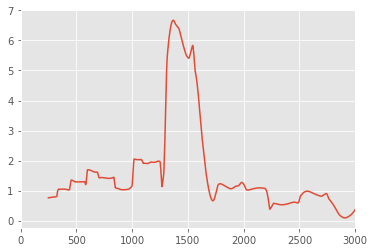

In [45]:
volList.plot()